In [0]:
import pandas as pd
import numpy as np
import datetime as dt

In [0]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from sklearn.model_selection import ParameterGrid

In [0]:
# util
def mcar_test(data):
    """ Implementation of Little's MCAR test
    Parameters
    ----------
    data: Pandas DataFrame
        An incomplete dataset with samples as index and variables as columns
    Returns
    -------
    p_value: Float
        This value is the outcome of a chi-square statistical test, testing whether the null hypothesis
        'the missingness mechanism of the incomplete dataset is MCAR' can be rejected.
    """
    import math as ma
    import scipy.stats as st
    import numpy as np
    import pandas as pd
    
    # helper function
    def checks_input_mcar_tests(data):
        """ Checks whether the input parameter of class McarTests is correct
            Parameters
            ----------
            data:
                The input of McarTests specified as 'data'
            Returns
            -------
            bool
                True if input is correct
        """
        if not isinstance(data, pd.DataFrame):
            print("Error: Data should be a Pandas DataFrame")
            return False
        if not any(data.dtypes.values == np.float):
            if not any(data.dtypes.values == np.int):
                print("Error: Dataset cannot contain other value types than floats and/or integers")
                return False
        if not data.isnull().values.any():
            print("Error: No NaN's in given data")
            return False
        return True
    
    if not checks_input_mcar_tests(data):
        raise Exception("Input not correct")

    dataset = data.copy()
    vars = dataset.dtypes.index.values
    n_var = dataset.shape[1]

    # mean and covariance estimates
    # ideally, this is done with a maximum likelihood estimator
    gmean = dataset.mean()
    gcov = dataset.cov()

    # set up missing data patterns
    r = 1 * dataset.isnull()
    mdp = np.dot(r, list(map(lambda x: ma.pow(2, x), range(n_var))))
    sorted_mdp = sorted(np.unique(mdp))
    n_pat = len(sorted_mdp)
    correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
    dataset['mdp'] = pd.Series(correct_mdp, index=dataset.index)

    # calculate statistic and df
    pj = 0
    d2 = 0
    for i in range(n_pat):
        dataset_temp = dataset.loc[dataset['mdp'] == i, vars]
        select_vars = ~dataset_temp.isnull().any()
        pj += np.sum(select_vars)
        select_vars = vars[select_vars]
        means = dataset_temp[select_vars].mean() - gmean[select_vars]
        select_cov = gcov.loc[select_vars, select_vars]
        mj = len(dataset_temp)
        parta = np.dot(means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1])))
        d2 += mj * (np.dot(parta, means))
    df = pj - n_var
    # perform test and save output
    p_value = 1 - st.chi2.cdf(d2, df)
    return p_value

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df = pd.read_csv("gdrive/My Drive/fully_filtered_rrt.csv")

In [0]:
# > 90, change it to 91.4
df['age_yr'] = df['age_yr'].apply(lambda x: x if x<=90 else 91.4)
tot = len(df['first_wardid'])
diff_list = []
for i in range(tot):
  if df['first_wardid'][i]!=df['last_wardid'][i]:
    diff_list.append(1)
  else:
    diff_list.append(0)
sum(diff_list)
df['Ward_changed'] = pd.Series(diff_list)
# set index
df.set_index('icustay_id',inplace=True)
# race
def race(x):
  if x in ['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN']:
    return "white"
  elif x in ['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN' , 'BLACK/AFRICAN', 'CARIBBEAN ISLAND']:
    return "black"
  elif x in ['HISPANIC OR LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)','HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - COLOMBIAN' , 'HISPANIC/LATINO - HONDURAN']:
    return "hispanic"
  elif x in ['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN', 'ASIAN - OTHER', 'ASIAN - KOREAN', 'ASIAN - JAPANESE', 'ASIAN - THAI']:
    return "asian"
  elif x in ['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']:
    return "native"
  elif x in ['UNKNOWN/NOT SPECIFIED', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']:
    return "unknown"
  else:
    return "other"
df['ethnicity'] = df['ethnicity'].apply(race)
# change datatype
check = ['congestive_heart_failure','cardiac_arrhythmias','valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']
for column in check:
  df[column] = df[column].astype('int64')

In [0]:
group = ['subject_id','hadm_id']
cat_frs = ['first_careunit','gender','was_ventilated_24h','ethnicity','admission_type']
cont_frs = ['age_yr','oasis',
       'height', 'weight', 'heartrate_min', 'heartrate_max', 'heartrate_mean',
       'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max',
       'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
       'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
       'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
       'glucose_min', 'glucose_max', 'glucose_mean',
       'sapsii_score', 'sofa_score', 'los_preicu', 'max_kdigo']

In [0]:
X.columns

Index(['first_careunit', 'gender', 'age_yr', 'admission_type', 'ethnicity',
       'oasis', 'height', 'weight', 'heartrate_min', 'heartrate_max',
       'heartrate_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min',
       'diasbp_max', 'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
       'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
       'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
       'glucose_min', 'glucose_max', 'glucose_mean', 'sapsii_score',
       'sofa_score', 'los_preicu', 'wtdiff', 'max_kdigo', 'was_ventilated_24h',
       'congestive_heart_failure', 'cardiac_arrhythmias', 'valvular_disease',
       'pulmonary_circulation', 'peripheral_vascular', 'hypertension',
       'paralysis', 'other_neurological', 'chronic_pulmonary',
       'diabetes_uncomplicated', 'diabetes_complicated', 'hypothyroidism',
       'renal_failure', 'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 

In [0]:
columns_to_drop = ['Unnamed: 0', 'min_ph_icustay', 'sepsis3', 'esrd', 'los', 'row_id','dbsource','last_careunit','first_wardid','last_wardid','intime','outtime','crrt_durations','crrt','dob','dod',
       'dod_hosp', 'expire_flag','admittime','dischtime', 'deathtime','diagnosis', 'hospital_expire_flag','max_kdigo_time']

In [0]:
df['was_ventilated_24h'] = df['was_ventilated_24h'].astype(int).astype(str)
df['was_ventilated_24h'].fillna('missing', inplace=True)

ValueError: ignored

In [0]:
df2 = df.drop(columns = columns_to_drop,axis = 1)

In [0]:
df2.info()

In [0]:
X = df2.drop(['rrt', 'subject_id', 'hadm_id'], axis=1)
y = df2['rrt']
print(y.value_counts()/len(y))
classes, counts = np.unique(y,return_counts=True)
print('balance:',np.max(counts/len(y)))

In [0]:
mcar_test(X[cont_frs])

0.0

In [0]:
# still working on this
def ML_pipeline_groups_GridSearchCV(X,y,groups,random_state,n_folds):
  splitter = GroupShuffleSplit(n_splits=4,test_size=0.2,random_state=random_state)
  for i_other,i_test in splitter.split(X, y, groups):
    X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
    X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
    # check the split
#     print(pd.unique(groups))
#     print(pd.unique(groups_other))
#     print(pd.unique(groups_test))
    # splitter for _other
    kf = GroupKFold(n_splits=n_folds)


In [0]:
# still working on this
imputer = SimpleImputer(estimator = RandomForestRegressor(),random_state=random_state)
standard_transformer = Pipeline(steps=[('imputer', imputer),('standard', StandardScaler())])
onehot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
                                               ('standard', standard_transformer, cont_frs),
                                               ('onehot', onehot_transformer, cat_frs)])
    return X_other, X_test, y_other, y_test, kf, preprocessor

IndentationError: ignored

In [0]:
# still working on this
param_grid = {'svc__C': np.logspace(-3,4,num=8),'svc__gamma': np.logspace(-3,4,num=8)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    grid.fit(X_other, y_other, groups_other)
    return grid, grid.score(X_test, y_test)


IndentationError: ignored

In [0]:
……æΩ≈ ˆπædef preprocess_with_impute(X,y,random_state,n_folds):
    '''
    
    '''
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)
    imputer = SimpleImputer()
    standard_transformer = Pipeline(steps=[('imputer', imputer),('standard', StandardScaler())])
    onehot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(
    transformers=[
        ('standard', standard_transformer, cont_frs),])
        ('onehot', onehot_transformer, cat_frs)])
    return X_other, X_test, y_other, y_test, kf, preprocessor

def ML_pipeline_logit_GridSearchCV(X_other, X_test, y_other, y_test, kf, preprocessor, random_state):
    logreg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(penalty='l1',random_state=random_state,multi_class='auto'))])
    param_grid = { 
    'classifier__C': np.logspace(-2,2,num=4)
    }
    grid = GridSearchCV(logreg, param_grid=param_grid,scoring = make_scorer(accuracy_score,greater_is_better=True),
                        cv=kf, return_train_score = True,iid=True)
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test)

IndentationError: ignored

In [0]:
X_other, X_test, y_other, y_test, kf, preprocessor = preprocess_with_impute(X,y,42,4)

In [0]:
X_other.shape

(7268, 69)

In [0]:
y_other.shape

(7268,)

In [0]:
X_other.head()

,first_careunit,gender,age_yr,admission_type,ethnicity,oasis,height,weight,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,meanbp_max,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean,sapsii_score,sofa_score,los_preicu,wtdiff,max_kdigo,was_ventilated_24h,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression,Ward_changed
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
282753,CCU,M,65.0,EMERGENCY,black,35,187.96,141.0,84.0,155.0,129.485714,67.0,154.0,92.333333,48.0,86.0,63.181818,57.0,84.0,69.121212,16.0,32.0,27.548387,36.333333,37.000000,36.756944,93.0,100.0,96.800000,223.0,247.0,233.500000,50,3,0.099444,16.26,3.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,1,0,0,0,0,0,0,0
288768,MICU,M,47.0,EMERGENCY,white,44,175.26,104.8,69.0,112.0,90.608696,56.0,141.0,107.880000,48.0,78.0,60.080000,51.0,92.0,73.480000,19.0,32.0,25.933333,37.388889,37.666667,37.509259,92.0,100.0,98.000000,116.0,319.0,177.428571,51,15,0.000995,NaN,2.0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1,0,0,0,0,0,0,0
206384,TSICU,F,45.0,EMERGENCY,white,31,170.18,61.3,84.0,110.0,100.741935,98.0,150.0,116.818182,51.0,93.0,62.333333,70.0,116.0,82.000000,16.0,26.0,21.897436,34.388889,37.300000,35.849206,99.0,100.0,99.935484,78.0,237.0,137.090909,33,8,0.001100,4.50,2.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,0
298594,MICU,F,50.0,EMERGENCY,black,44,152.40,146.6,107.0,152.0,119.806452,65.0,151.0,111.333333,25.0,71.0,52.933333,45.0,91.0,66.700000,2.0,33.0,16.966667,36.500000,37.333333,36.981481,91.0,100.0,99.322581,150.0,251.0,207.200000,36,7,5.332280,12.30,2.0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1,0,0,0,0,0,0,0
210788,MICU,M,58.0,EMERGENCY,white,39,157.48,73.7,49.0,65.0,55.608696,83.0,163.0,109.772727,51.0,139.0,65.363636,58.0,144.0,76.391304,8.0,22.0,14.354839,35.333333,36.000000,35.746032,93.0,100.0,96.869565,138.0,177.0,157.500000,47,6,0.000822,0.30,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0


In [0]:
logreg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(penalty='l2',random_state=42,multi_class='auto',verbose=4))])
logreg.fit(X_other, y_other)
logreg.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


0.8899284534947716

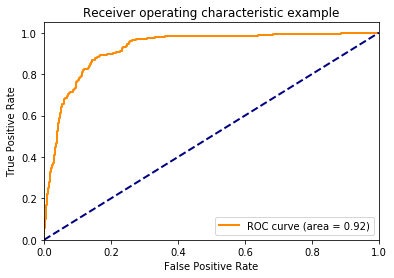

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

n_classes = 2

y_score = logreg.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

i=0
fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()